### Importing the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import re
import string
import nltk
import os
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Importing the data file

In [4]:
df = pd.read_csv('sample30.csv')

## EDA

we will check the some basic properties of the data we imported

In [5]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [6]:
df.shape

(15271, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15271 entries, 0 to 15270
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    15271 non-null  object
 1   brand                 15271 non-null  object
 2   categories            15271 non-null  object
 3   manufacturer          15271 non-null  object
 4   name                  15271 non-null  object
 5   reviews_date          15257 non-null  object
 6   reviews_didPurchase   8928 non-null   object
 7   reviews_doRecommend   14702 non-null  object
 8   reviews_rating        15271 non-null  int64 
 9   reviews_text          15271 non-null  object
 10  reviews_title         15214 non-null  object
 11  reviews_userCity      1255 non-null   object
 12  reviews_userProvince  35 non-null     object
 13  reviews_username      15228 non-null  object
 14  user_sentiment        15270 non-null  object
dtypes: int64(1), object(14)
memory usage

In [8]:
#find the percentage of null values in each column to determine columns to be dropped
pd.set_option('display.max_rows', 120) #to display all rows
print(round(100*(df.isnull().sum()/len(df.index)), 2))

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.00
name                     0.00
reviews_date             0.09
reviews_didPurchase     41.54
reviews_doRecommend      3.73
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.37
reviews_userCity        91.78
reviews_userProvince    99.77
reviews_username         0.28
user_sentiment           0.01
dtype: float64


Will use some of the features to perform some EDA and later go on with cleaning of the dataset

## Univariate Analysis

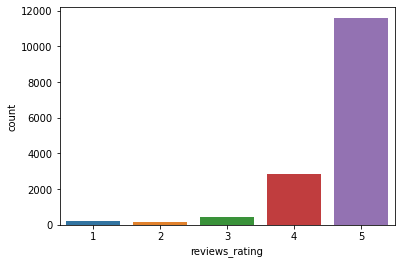

In [9]:
#checking the spread of ratings given by the customers
sns.countplot(x = 'reviews_rating', data = df)
plt.show()

In [10]:
df['reviews_rating'].value_counts()

5    11597
4     2837
3      453
1      244
2      140
Name: reviews_rating, dtype: int64

### So on top of the head we can see that major share of the ratings lies on good side or higher side, thus there is definately a imbalance present in the data.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15271 entries, 0 to 15270
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    15271 non-null  object
 1   brand                 15271 non-null  object
 2   categories            15271 non-null  object
 3   manufacturer          15271 non-null  object
 4   name                  15271 non-null  object
 5   reviews_date          15257 non-null  object
 6   reviews_didPurchase   8928 non-null   object
 7   reviews_doRecommend   14702 non-null  object
 8   reviews_rating        15271 non-null  int64 
 9   reviews_text          15271 non-null  object
 10  reviews_title         15214 non-null  object
 11  reviews_userCity      1255 non-null   object
 12  reviews_userProvince  35 non-null     object
 13  reviews_username      15228 non-null  object
 14  user_sentiment        15270 non-null  object
dtypes: int64(1), object(14)
memory usage

In [12]:
#Checking the unique brands,manufacturers and categories present in this dataset
print("number of unique brands :        ",len(df['brand'].unique()),'\n'
     "number of unique manufacturers : ",len(df['manufacturer'].unique()),'\n'
     "number of uniquer categories :   ",len(df['categories'].unique()))

number of unique brands :         85 
number of unique manufacturers :  88 
number of uniquer categories :    92


In [13]:
#Function to print the count graph for brands and manufactures, divided the total items in brands having reviews less than
# equal to 10 and more than 10 , same for manufacturers
def plot_graph(df,feature,flag):
     if flag == 0:
         a = df[feature].value_counts()
         a1 = list(a[a.values<=10].index)
         df_temp = df.loc[df[feature].isin(a1)]
         a1_dims = (14, 10)
         fig, fx = plt.subplots(figsize=a1_dims)
         cx = sns.countplot(x = feature, data = df_temp)
         plt.xlabel(feature + ' having reviews less than equal to 10')
         plt.tight_layout()
         plt.xticks(rotation=90)
         plt.tick_params(axis='x', which='major', labelsize=7)
         plt.show()
     else :
         a = df[feature].value_counts()
         a1 = list(a[a.values>10].index)
         df_temp = df.loc[df[feature].isin(a1)]
         a1_dims = (14, 10)
         fig, fx = plt.subplots(figsize=a1_dims)
         cx = sns.countplot(x = feature, data = df_temp, log = True)
         plt.xlabel(feature + ' having reviews more than 10')
         plt.tight_layout()
         plt.xticks(rotation=90)
         plt.tick_params(axis='x', which='major', labelsize=7)
         plt.show()

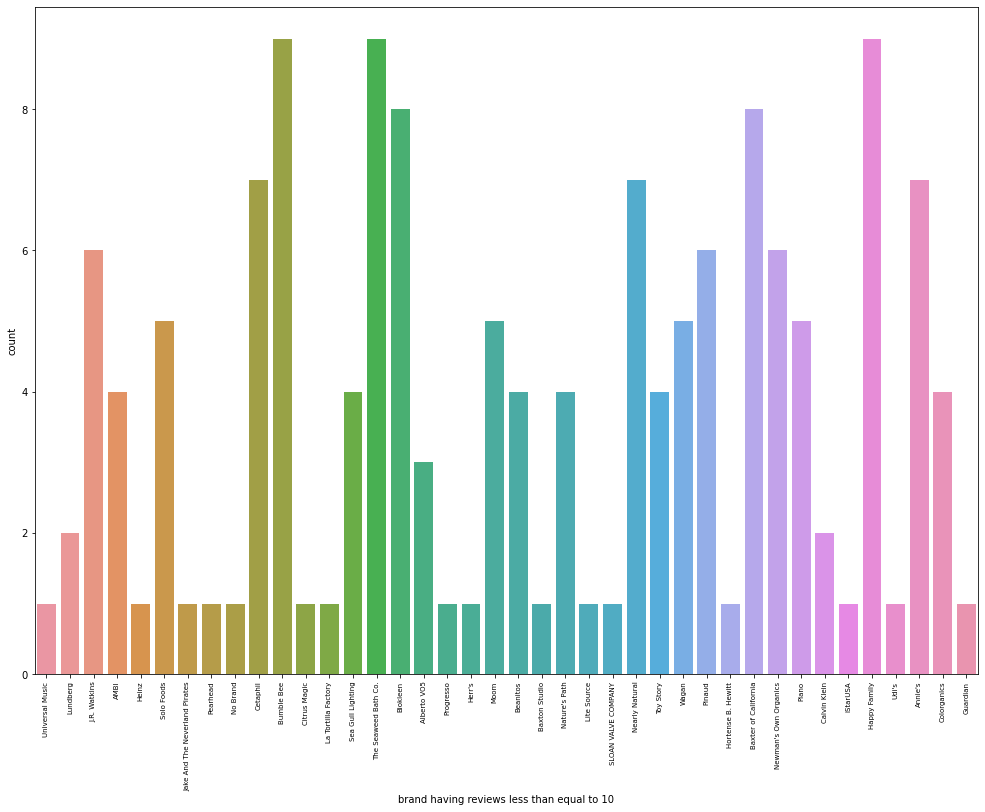

In [14]:
#for brands having reviews less than equal to 10 reviews
plot_graph(df,'brand',0)

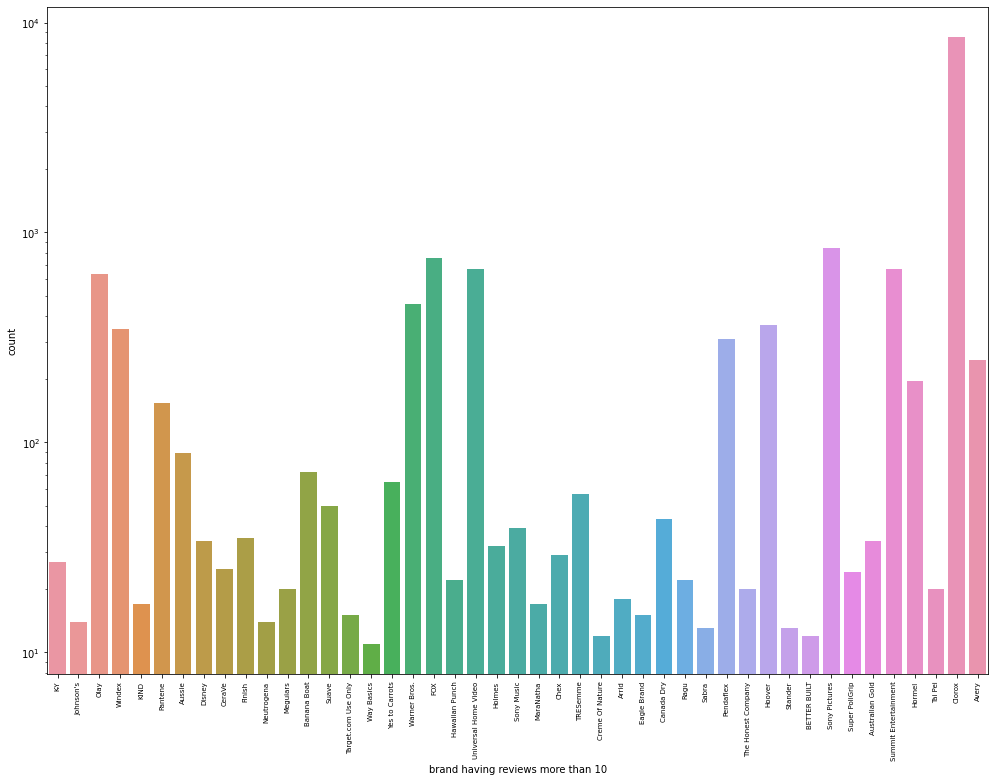

In [15]:
#for brands having reviews more than equal 10 reviews
plot_graph(df,'brand',1)

On seeing the above 2 plots we can see that there is a uniformity in the review counts for the products having less than 11 reviews while the products having review more than 10 there is a high review count for select few brands.

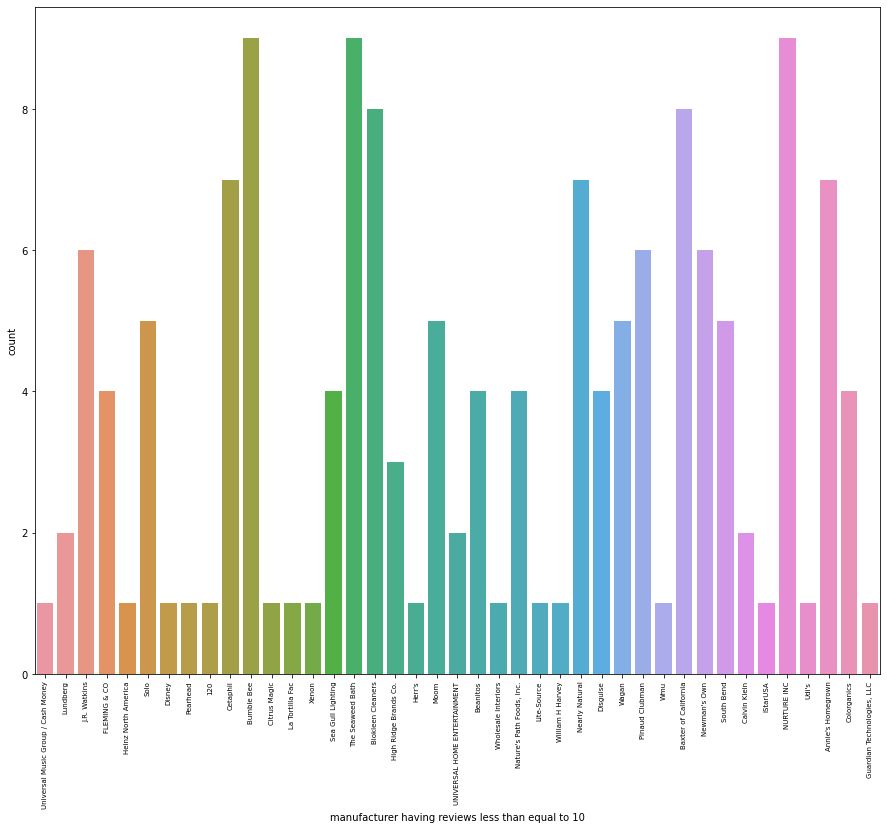

In [16]:
#for manufaturers having reviews less than equal to 10 reviews
plot_graph(df,'manufacturer',0)

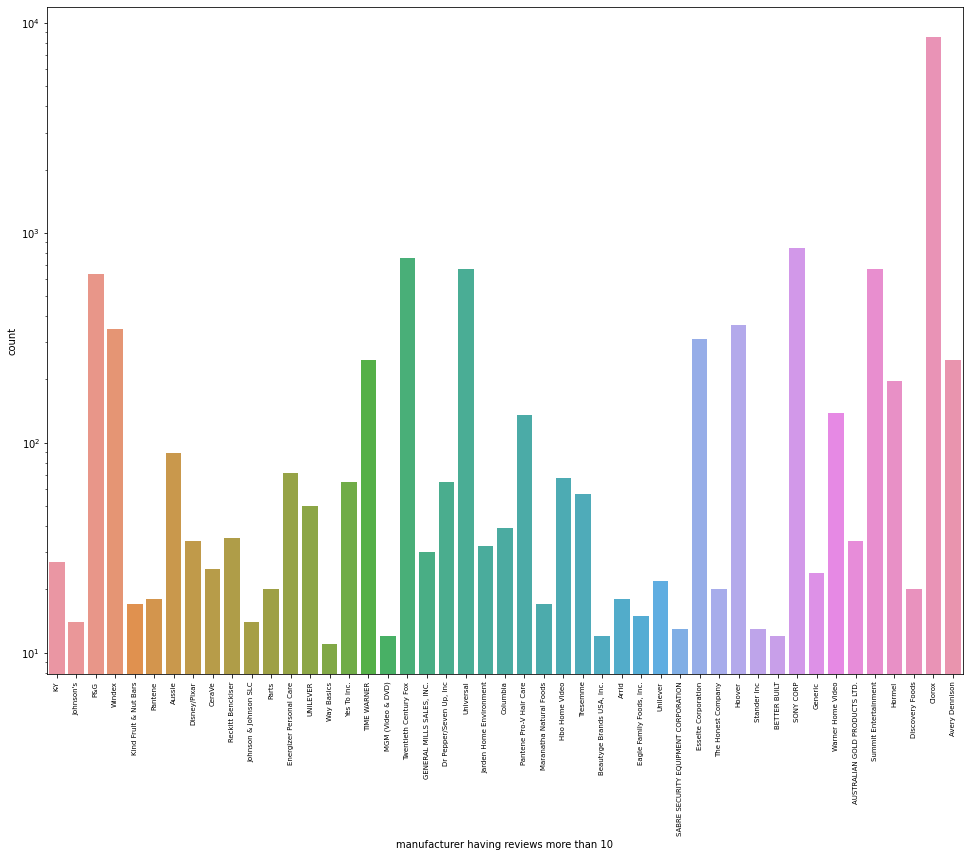

In [17]:
#for brands having reviews more than equal 10 reviews
plot_graph(df,'manufacturer',1)

A similar trend is seen as that of the brands, mostly brands are same as manufacturers

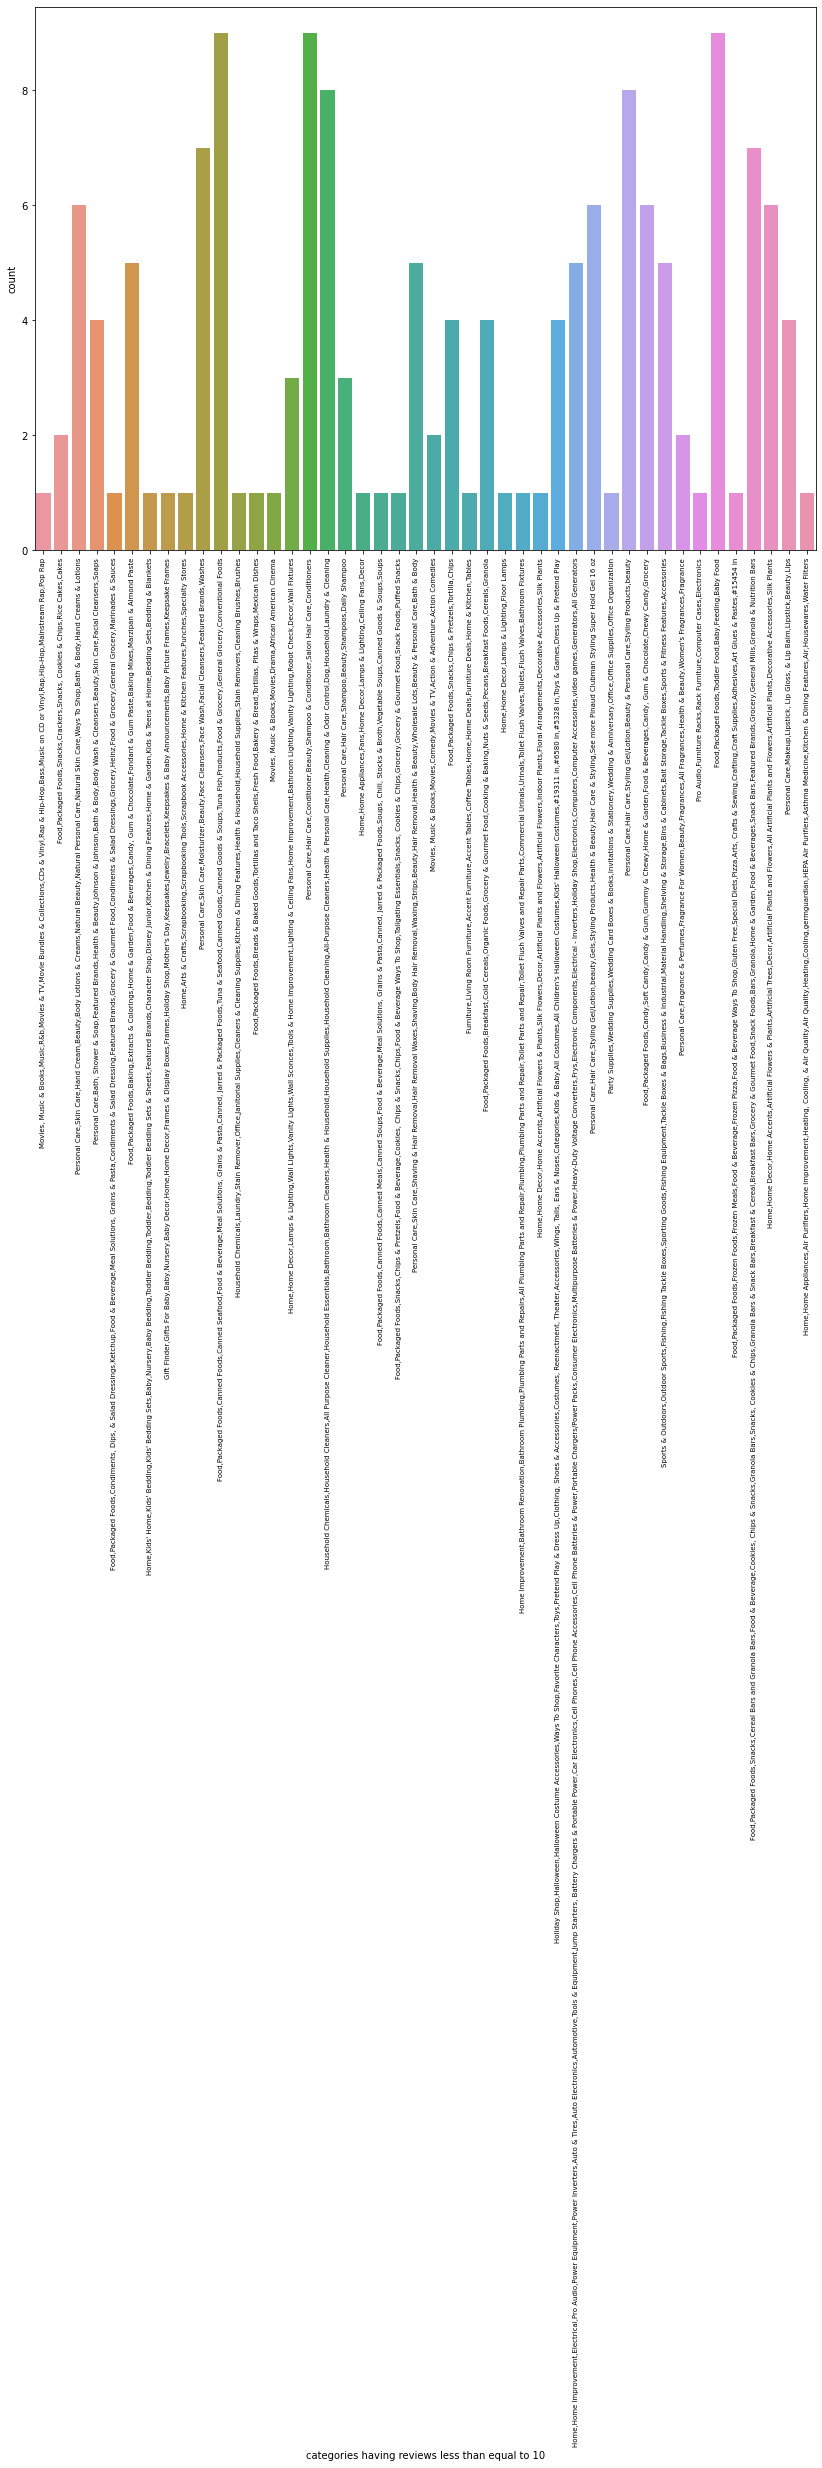

In [18]:
#for categories having reviews less than equal to 10 reviews
plot_graph(df,'categories',0)

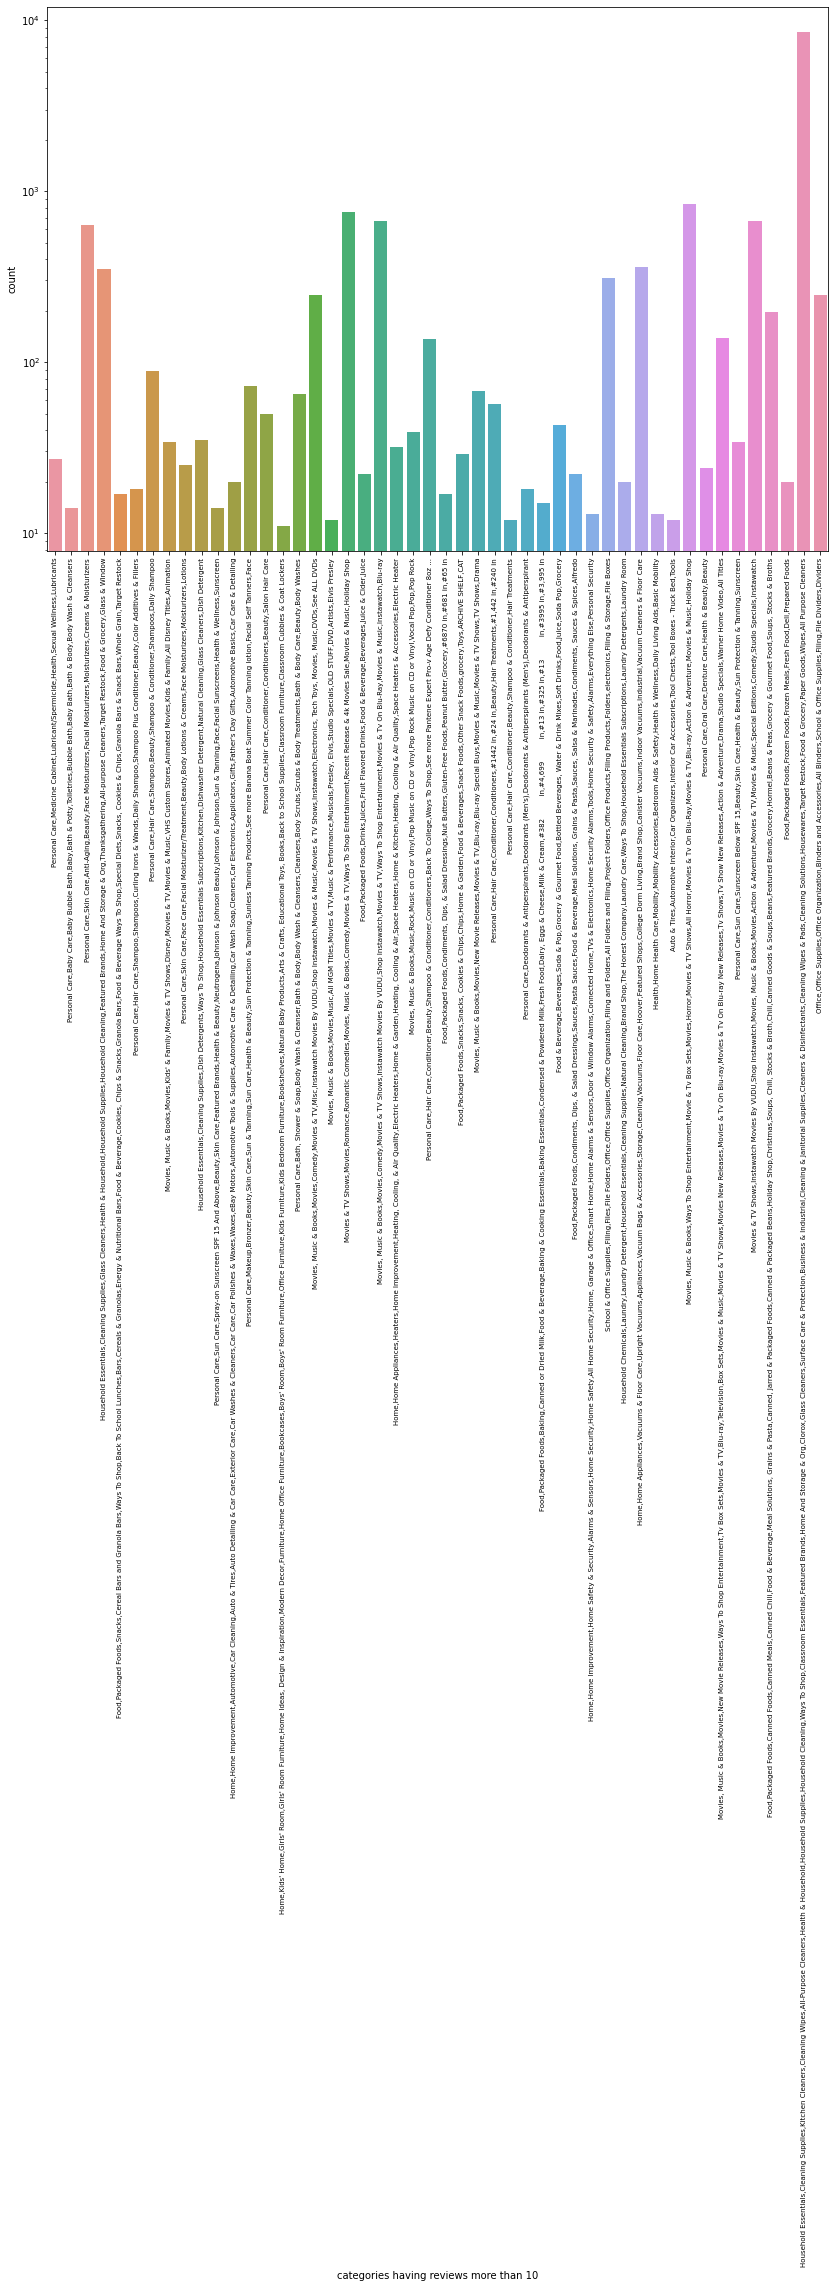

In [19]:
#for categories having reviews more than 10 reviews
plot_graph(df,'categories',1)

In [20]:
# we will take the top 50 products for our analysis
df['name'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  8545
The Resident Evil Collection 5 Discs (blu-Ray)                                                              845
Mike Dave Need Wedding Dates (dvd + Digital)                                                                757
Red (special Edition) (dvdvideo)                                                                            672
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                                        668
Olay Regenerist Deep Hydration Regenerating Cream                                                           634
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com               362
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                                                       348
Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack                         

In [21]:
#no of unique products present in dataset
len(df['name'].unique())

92

In [22]:
#creating a temp data frame for top 50 products
df_top50 = df.loc[df['name'].isin(list(df['name'].value_counts()[0:49].index))]

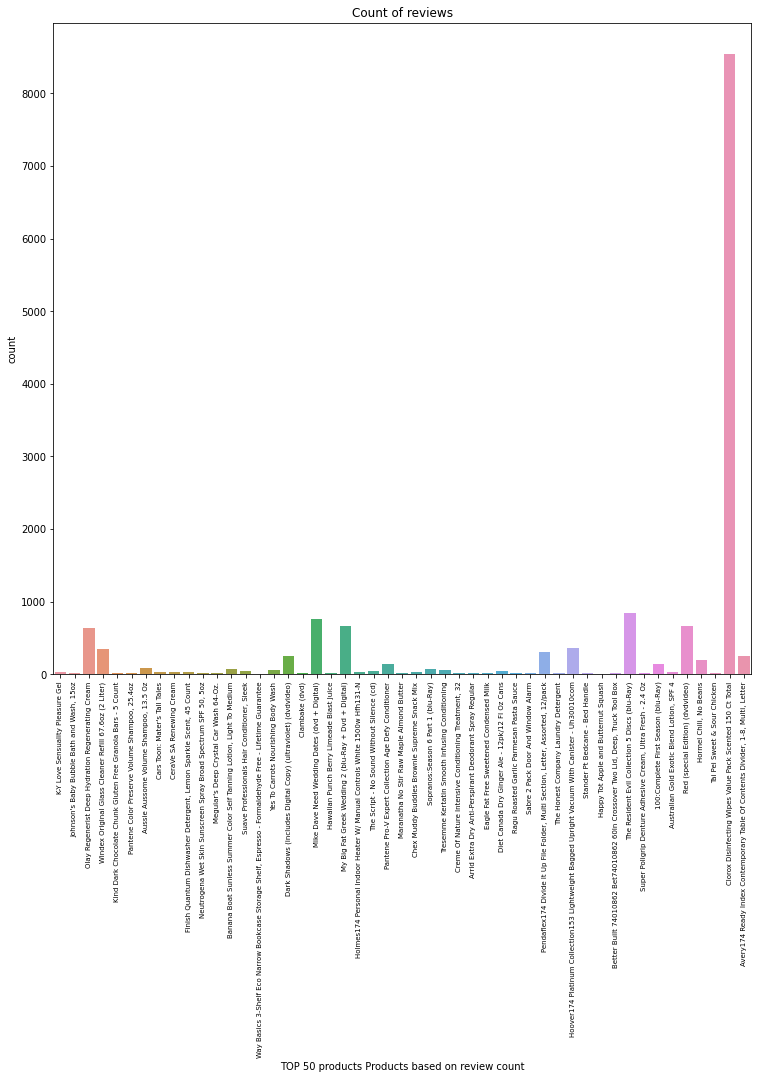

In [23]:
#plot for the top 50 prod
top50_dims = (14, 10)
fig, fx = plt.subplots(figsize=top50_dims)
cx = sns.countplot(x = 'name', data = df_top50)
plt.xlabel('TOP 50 products Products based on review count')
plt.title('Count of reviews')
plt.tight_layout()
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.show()

From the above plot it is evident how imbalance the data is in the data set which needs to be treated before proceeding for modelling

In [24]:
df['reviews_didPurchase'].value_counts()

False    8429
True      499
Name: reviews_didPurchase, dtype: int64

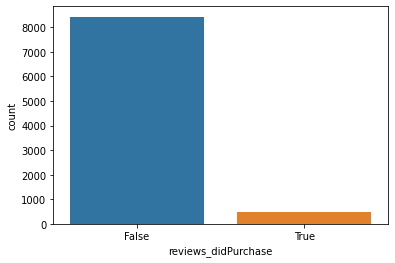

In [25]:
sns.countplot(x = 'reviews_didPurchase' , data = df)
plt.show()

Here as well we can see the imbalance in the class, for the missing values even if we assume they did not buy the product leaves us with almost 46% missing value

In [26]:
# we will take the top 100 title for our analysis
df['reviews_title'].value_counts()

Great Product                                308
Clorox Wipes                                 269
Great product                                136
Great movie                                  126
Great                                        126
                                            ... 
Platinum Series Vacuum Cleaner - Bagged        1
Worth the buy                                  1
Feels like it will last                        1
A very good product for a very good price      1
Great for Yearly Reports                       1
Name: reviews_title, Length: 9310, dtype: int64

In [27]:
#no of unique products present in dataset
len(df['reviews_title'].unique())

9311

In [28]:
#creating a temp data frame for top 100 titles
df_top50_t = df.loc[df['reviews_title'].isin(list(df['reviews_title'].value_counts()[0:99].index))]

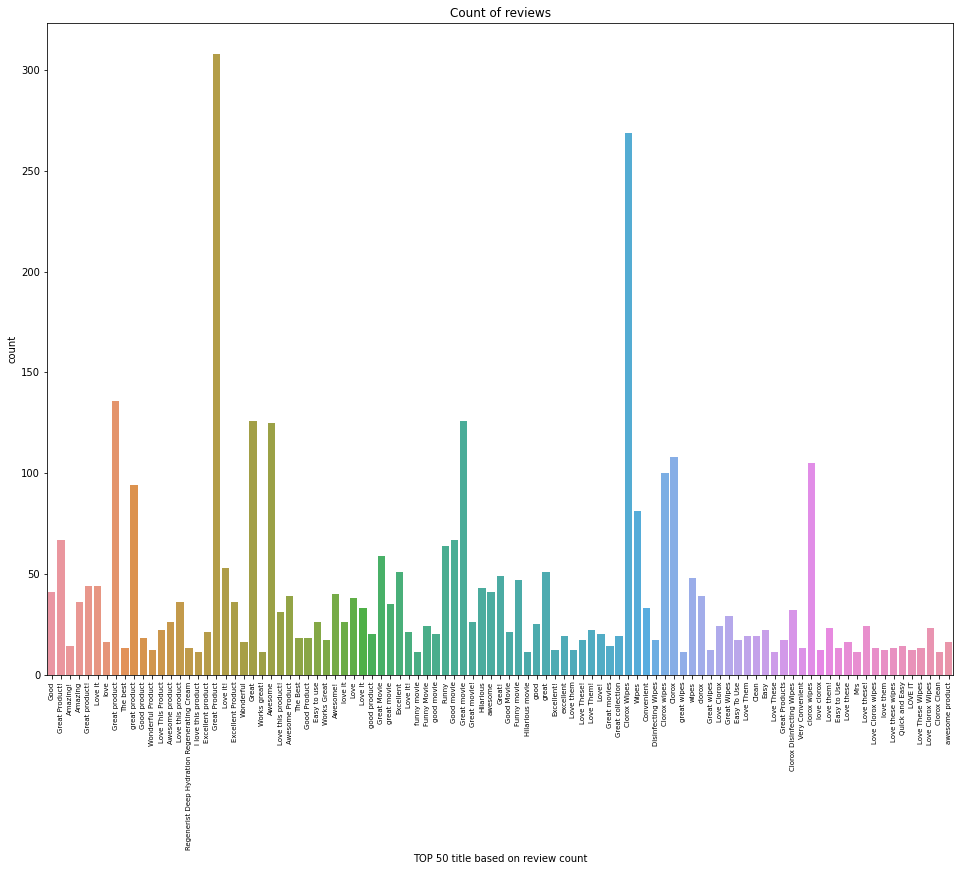

In [29]:
#plot for the top 50 prod
top50_dims = (14, 10)
fig, fx = plt.subplots(figsize=top50_dims)
cx = sns.countplot(x = 'reviews_title', data = df_top50_t)
plt.xlabel('TOP 50 title based on review count')
plt.title('Count of reviews')
plt.tight_layout()
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.show()

Browsing through it seems mostly are having a positive review

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15271 entries, 0 to 15270
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    15271 non-null  object
 1   brand                 15271 non-null  object
 2   categories            15271 non-null  object
 3   manufacturer          15271 non-null  object
 4   name                  15271 non-null  object
 5   reviews_date          15257 non-null  object
 6   reviews_didPurchase   8928 non-null   object
 7   reviews_doRecommend   14702 non-null  object
 8   reviews_rating        15271 non-null  int64 
 9   reviews_text          15271 non-null  object
 10  reviews_title         15214 non-null  object
 11  reviews_userCity      1255 non-null   object
 12  reviews_userProvince  35 non-null     object
 13  reviews_username      15228 non-null  object
 14  user_sentiment        15270 non-null  object
dtypes: int64(1), object(14)
memory usage

## Bivariate Analysis

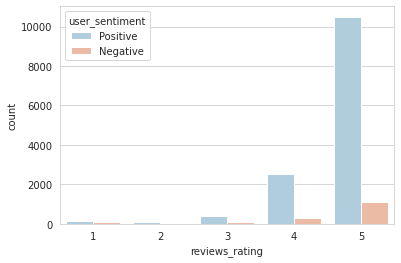

In [31]:
#checking the effect of reviews_rating column on target column user_sentiment
sns.set_style('whitegrid')
sns.countplot(x = 'reviews_rating', hue = 'user_sentiment', data = df, palette='RdBu_r')
plt.show()

As seen in the above visualization the data is highly imbalance, an important observation is that people are still not having a positive sentiment even when 5 rating has been given. This difference in ratio  is larger when compared to 4 star rating category

# Data pre-processing for user_sentiment column
##### we can see that it has only a single null entry which we can manually set as +ve or -ve by checking the review text against it

In [32]:
#Setting max column display to read complete review
pd.set_option('display.max_colwidth',None)

In [33]:
#checking the text of the review present
df['reviews_text'][df['user_sentiment'].isnull()]

15270    This is my first Avery product and I am very happy with my purchase. I made the cutest dividers for nursing school!
Name: reviews_text, dtype: object

In [34]:
#checking the rating given by the user
df['reviews_rating'][df['user_sentiment'].isnull()]

15270    5
Name: reviews_rating, dtype: int64

#### As evident from the above review text and the review rating we can safely assume that this is a positive sentiment

In [35]:
#making the missing value as Positive sentiment
df['user_sentiment'].fillna('Positive', inplace = True)

In [36]:
df['user_sentiment'].value_counts()

Positive    13631
Negative     1640
Name: user_sentiment, dtype: int64

In [37]:
#We are changing the sentiments in form of 1 for positive and 0 for negative
df['user_sentiment'] = df['user_sentiment'].apply(lambda x : 1 if x == 'Positive' else 0)

In [38]:
df['user_sentiment'].value_counts()

1    13631
0     1640
Name: user_sentiment, dtype: int64

In [39]:
#checking for brands having most positive rating.
df_brand = df.pivot_table(index = 'brand', columns = 'reviews_rating', values = 'user_sentiment', aggfunc=np.sum, margins= True)

In [40]:
df_brand

reviews_rating,1,2,3,4,5,All
brand,,,,,,
AMBI,NaN,NaN,NaN,1.0,3.0,4
Alberto VO5,NaN,NaN,NaN,NaN,2.0,2
Annie's,NaN,NaN,0.0,NaN,5.0,5
Arrid,1.0,NaN,NaN,2.0,9.0,12
Aussie,5.0,1.0,4.0,25.0,47.0,82
Australian Gold,NaN,NaN,NaN,3.0,25.0,28
Avery,NaN,NaN,6.0,23.0,208.0,237
BETTER BUILT,NaN,NaN,NaN,1.0,10.0,11
Banana Boat,3.0,0.0,5.0,19.0,40.0,67


In [41]:
def plot_graph2(df,rating,ax):
     df_temp = df[rating].nlargest(n=11).to_frame()
     df_temp.reset_index(inplace = True)
     sns.barplot(x = 'brand',y = rating, data = df_temp, log = True,ax = ax)
     a = str(rating)
     plt.ylabel('total number of +ve sentiments')
     plt.title('top 10 brands in rating category '+a)
     plt.xticks(rotation=90)

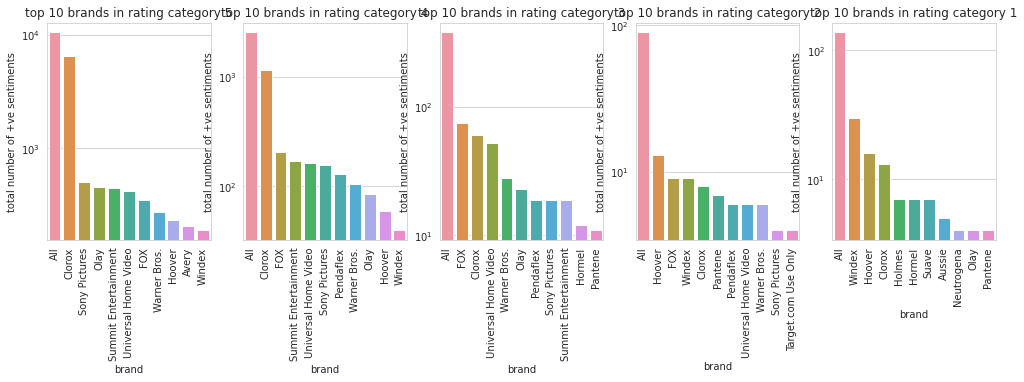

In [42]:
plt.figure(figsize=(17,4))
ax1 = plt.subplot(1,5,1)
plot_graph2(df_brand,5,ax1)
ax2 = plt.subplot(1,5,2)
plot_graph2(df_brand,4,ax2)
ax3 = plt.subplot(1,5,3)
plot_graph2(df_brand,3,ax3)
ax4 = plt.subplot(1,5,4)
plot_graph2(df_brand,2,ax4)
ax5 = plt.subplot(1,5,5)
plot_graph2(df_brand,1,ax5)

Thus as we can see in the above graph that how the rating 4 and 5 are dominated by a single brand and later the leader brand gets changed as rating drop to 3 and below

# Data cleaning and pre-processing

We had observed in one of the bivariate analysis that the sentiment for a few reviews were given as negative even though the rating was 4 or 5, we will check few of these and if found a data error will fix the same

In [43]:
df[(df["user_sentiment"]==0) & (df["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,4
96,This product has made a real difference on my skin,In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.,4
100,Noticed a difference in just two weeks!,This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.,4
106,Very rich cream,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.",4
117,Not greasy,"I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.",4
...,...,...,...
15130,An appropriate number of sections,I wish that an extra table of content sheet was either included or sold separately for when the printers messes up alignment.,5
15131,Great when you need a lot of sections,I wish that an extra table of content sheet was either included or sold separately for when the printers messes up alignment.,5
15146,Boy Scout Resource Manual,"I use this index maker/Divider in a binder to create a reference manual for new Boy Scouts. I insert a picture, like say of the uniform shirt and then the words Uniform Standards to associate with each tab... I end up with five tabs... Advancement and Rank, Uniform Standards, Troop Song Book, Troop Calendar, and Other Information. This way they have a quick guide that the parents can use also. It really helps cut down answering the routine questions that occur when they are new.",5
15159,Quality in A 1!,"I only use Avery products in my work...I can count on the quality, usefulness and durability of the dividers. My business is insurance and you can imagine the binders and the number of times we are referencing our binders. The tabs do not tear or bend and last throughout the year.",5


As we can see in the above records, we can assign the positive user_sentiment, i.e. 1 to the user_sentiment column for the reviews having rating greater than equal to 4

Checking the same clause for the reviews having positive rating for products having less than 4 rating

In [44]:
df[(df["user_sentiment"]==1) & (df["reviews_rating"]<=3)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
9,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,1
11,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,1
14,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.,1
18,Pretty nice,"I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol",3
54,New formula is terrible,"I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.",1
...,...,...,...
15025,Wish Sat/Sun weren't combined,"I use these tabs primarily to help with cookbook creation and meal planning. Not everyone lives by the standard American workweek of M-F (including my stomach!). I wish that Avery would also make this set with 7 or 8 tabs, with Saturday and Sunday on separate tabs. With 8 tabs, a blank at the end would be helpful, so I can store misc. information behind my full week. Thanks for the consideration.",3
15026,Index Page Concerns,I use indexes as I prepare various notebooks for later use. Having the list of pages and their titles as a permenant entry doesn't leave flexability to relocate sections. Could do a draft page first then make a permenant index page.,3
15027,Index page concerns,I use indexes as I prepare various notebooks for later use. Having the list of pages and their titles as a permenant entry doesn't leave flexability to relocate sections. Could do a draft page first then make a permenant index page.,3
15028,11321 Table of Contents,If the paper could be a harder more durable card stock I would rate it a 5. It is a wonderful product. A little pricey for what you get.,3


As evident from the majority of the records obtained, we can put 0 (negative) as user_sentiment for the reviews having rating less than equal to 3

In [45]:
#creating a subset df to make all the cleaning and data adjustment and modelling
df_correction = df[['id','name','reviews_rating','reviews_text','reviews_title','user_sentiment']]

In [46]:
#creating a crosstab to check the total count for each rating category
pd.crosstab(df_correction["user_sentiment"], df_correction["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,106,51,75,305,1103,1640
1,138,89,378,2532,10494,13631
All,244,140,453,2837,11597,15271


Thus as discussed in the above cell it seems that there is some ambiguity in the data which we can fix using the rule such as reviews having less than 4 rating will be set as -ve sentiment and reviews having rating as 4 or 5 will be set as +ve sentiment

In [47]:
#Giving a -ve sentiment to reviews having rating as 1,2 or 3
df_correction.loc[(df_correction["user_sentiment"]==1) & (df_correction["reviews_rating"]<4), "user_sentiment"] = 0

In [48]:
#Giving a +ve sentiment to reviews having rating as 4 or 5
df_correction.loc[(df_correction["user_sentiment"]==0) & (df_correction["reviews_rating"]>3), "user_sentiment"] = 1

In [49]:
#Checking for the changes
pd.crosstab(df_correction["user_sentiment"], df_correction["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,244,140,453,0,0,837
1,0,0,0,2837,11597,14434
All,244,140,453,2837,11597,15271


In [50]:
df_correction.user_sentiment.value_counts()

1    14434
0      837
Name: user_sentiment, dtype: int64

As we can see in the above cell the data is highly imbalanced which needs to be taken care of

In [51]:
df_correction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15271 entries, 0 to 15270
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15271 non-null  object
 1   name            15271 non-null  object
 2   reviews_rating  15271 non-null  int64 
 3   reviews_text    15271 non-null  object
 4   reviews_title   15214 non-null  object
 5   user_sentiment  15271 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 716.0+ KB


In the current dataframe we have 2 text fields i.e. reviews_text and reviews_title we can use both of these in the text processing, perform text cleaning operations such as stopword removal , lematization , etc

In [52]:
#filling the missing data in title column with blank
df_correction["reviews_title"] = df_correction["reviews_title"].fillna('')

In [53]:
#concating the title and text in one single column removing all preceeding spaces
df_correction["reviews_combine"] = df_correction[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [54]:
df_correction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15271 entries, 0 to 15270
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               15271 non-null  object
 1   name             15271 non-null  object
 2   reviews_rating   15271 non-null  int64 
 3   reviews_text     15271 non-null  object
 4   reviews_title    15271 non-null  object
 5   user_sentiment   15271 non-null  int64 
 6   reviews_combine  15271 non-null  object
dtypes: int64(2), object(5)
memory usage: 835.3+ KB


In [55]:
df_correction.head()

,id,name,reviews_rating,reviews_text,reviews_title,user_sentiment,reviews_combine
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,1,Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part of a promotion.,Good,1,Good. Good flavor. This review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,1,Good. Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,0,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,0,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [56]:
df_correction[df_correction['reviews_combine'].str.contains('\[\s*\w*\s*\]')]

,id,name,reviews_rating,reviews_text,reviews_title,user_sentiment,reviews_combine
1924,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4,Mike and Dave Need Wedding Dates [Blu-ray/DVD] [2016] - good family movie.,Mike and Dave Need Wedding Dates,1,Mike and Dave Need Wedding Dates. Mike and Dave Need Wedding Dates [Blu-ray/DVD] [2016] - good family movie.
6075,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5,"Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed it was routine. The show is most likely one of the best spy counter spy flicks that I have seen. With a superb blend of senior casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside.",RED will not disappoint - its a great view.,1,"RED will not disappoint - its a great view.. Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed it was routine. The show is most likely one of the best spy counter spy flicks that I have seen. With a superb blend of senior casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside."
6247,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5,"Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed ??it was routine. The show is most likely one of the best spy ??counter spy flicks that I have seen. With a superb blend of ??enior??casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside.",RED will not disappoint - its a great view.,1,"RED will not disappoint - its a great view.. Opening Scene: The mundane daily routine of a retired CIA Covert Operative is exposed ??it was routine. The show is most likely one of the best spy ??counter spy flicks that I have seen. With a superb blend of ??enior??casting, sensitive directorship, and a very well-written plot-line of pure table-pounding action/intrigue entertainment this is the type of film you will visit again, and there is a twist around every corner that is guaranteed to keep your interest up! It is interesting that the plots star character, Frank [Francis], is a pure romantic with a hard exterior but is soft and gooey on the inside."


It seems like there are few words embedded in [] pair of bracket which can be removed from the dataset

In [57]:
#we will proceed to create a function to clean this new feature created
def clean_text(text_feature):
    text_feature = text_feature.lower() #making all text to lower
    text_feature = text_feature.strip() #removing spaces from start and end
    text_feature = re.sub("\[\s*\w*\s*\]", "", text_feature) # removing the text b/w []
    text_feature = re.sub(r'[^\w\s]', '', text_feature) # removing punctutions
    text_feature = re.sub("\S*\d\S*", "", text_feature) #removing digits
    return text_feature

In [58]:
df_correction['reviews_combine'] = df_correction['reviews_combine'].apply(lambda x : clean_text(x))

In [59]:
df_correction['reviews_combine'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it  rating all the way her metaphors are just crazy
1                                                                                                                                                                                                                                                                                                                    

The text looks clean now we will proceed to remove the stop words from the corpus

In [60]:
stop_words = set(stopwords.words("english"))

in the stop words list we can see a few words which are important for pointing out a negative review, words such as not, never , no, thus we will remove these words from the stop words list and they will be present in the corpus

In [61]:
ele_to_remove = ['no','not','never']
stop_words = stop_words - set(ele_to_remove)

In [62]:
if ('no' in stop_words) & ('not' in stop_words) & ('never' in stop_words):
    print('elements present')
else :
    print('elements successfully deleted')

elements successfully deleted


In [63]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'sam

In [64]:
from collections import Counter

In [65]:
# Remove stopwords function
def remove_stopwords(text,stop_words):
    words = text.split()
    stopwords_dict = Counter(stop_words)
    text = " ".join([word for word in words if word not in stopwords_dict])
    return text

In [66]:
df_correction['reviews_combine'] = df_correction['reviews_combine'].apply(lambda x : remove_stopwords(x,stop_words))

In [67]:
df_correction['reviews_combine'].head()

0                                                                                                                                                                                                                                                                                                                                         awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphors crazy
1                                                                                                                                                                                                                                                                                                                                                                                                        good good flavor review collected part promotion
2                                                                                                                   

#### Now once stop words have been removed we will be using lematization to reduce the words to their base form

In [68]:
# Using a helper function to get better lemetized result
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [69]:
#Lemmatize function
lemmatizer = WordNetLemmatizer()
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(text)) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(words)

In [70]:
df_correction["reviews_combine"] = df_correction['reviews_combine'].apply(lambda x: lemma_text(x))

In [71]:
df_correction['reviews_combine'].head()

0                                                                                                                                                                                                                                                                                                                 awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1                                                                                                                                                                                                                                                                                                                                                                                 good good flavor review collect part promotion
2                                                                                                                                                                     

In [72]:
df_correction.head()

,id,name,reviews_rating,reviews_text,reviews_title,user_sentiment,reviews_combine
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,1,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part of a promotion.,Good,1,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,1,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,0,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean not pleasant especially since lack captivate sensation expect im disappoint pay much lube wont use could use normal personal lubricant less money less mess
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,0,irritation husband buy gel u gel caused irritation felt like burn skin wouldnt recommend gel


In [73]:
#seperating the dependent and independent features
X = df_correction['reviews_combine']
y = df_correction['user_sentiment']

In [74]:
y.value_counts()

1    14434
0      837
Name: user_sentiment, dtype: int64

We can see that there is high imbalance in the data as +ve review is much more, thus we will use smote to overcome this

In [75]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True, 
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_correction['reviews_combine'])

In [76]:
#getting feature names
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'absolutely love' 'action' 'action movie' 'actor'
 'actually' 'add' 'age' 'ago' 'allow' 'amaze' 'amazing' 'apply' 'area'
 'ask' 'away' 'awesome' 'awesome love' 'awesome product' 'baby' 'bad'
 'bag' 'base' 'basis' 'bath' 'bathroom' 'bathroom kitchen'
 'bathroom review' 'beat' 'believe' 'best' 'best buy' 'best product'
 'best wipe' 'big' 'binder' 'bit' 'bleach' 'blu' 'blu ray' 'bluray' 'body'
 'bottle' 'box' 'box set' 'boy' 'brand' 'bring' 'bruce' 'bruce willis'
 'busy' 'buy' 'canister' 'car' 'care' 'carpet' 'carry' 'cast' 'change'
 'character' 'cheap' 'child' 'chili' 'classroom' 'clean' 'clean bathroom'
 'clean clorox' 'clean counter' 'clean disinfect' 'clean easy'
 'clean fresh' 'clean great' 'clean house' 'clean kitchen' 'clean love'
 'clean mess' 'clean product' 'clean review' 'clean smell' 'clean ups'
 'clean use' 'clean wipe' 'cleaner' 'cleaning' 'cleaning product'
 'cleanup' 'clorox' 'clorox brand' 'clorox clean' 'clorox disinfect'
 'clorox great' 'clorox love

In [77]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=92, test_size=0.25)

In [78]:
#SMOTE implementation
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 10802, 0: 651})
After Counter({1: 10802, 0: 10802})


# Model building

In [79]:
#importing necessary files for model building
import time
from sklearn import metrics
import pickle

In [80]:
#Utility function to display accuracy
def display_score(classifier):
    dm = confusion_matrix(y_test, classifier.predict(X_test))
    dis = ConfusionMatrixDisplay(confusion_matrix=dm, display_labels=classifier.classes_)
    dis.plot() 
    print(classifier)
    print('\n')
    print('Accuracy of the model is ', accuracy_score(y_test, classifier.predict(X_test)))
    print('Sensitivity of the model is {}'.format(cm[1][1]/sum(cm[1])))
    print('Specificity of the model is {}'.format(cm[0][0]/sum(cm[0])))

## Logistic Regression

### Using a class based approach for evaluating the models

In [81]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)
    
    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")
        
        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)
            
        print("*"*30)
        print("\n")
        
        metrics.plot_roc_curve(self.model, self.x_test, self.y_test)
        
        return self.result_metrics
        
    def evaluate_metrics(self, y_pred_class):
        result_metrics = [] 
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)
        
        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")
        
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics
        
    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])
        
        
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="PiYG", fmt=".2%")
 
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
 
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()
        
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

In [82]:
#importing logisting regression
from sklearn.linear_model import LogisticRegression

In [83]:
# Building a Logistic Regression model.
%time
logreg_ci = LogisticRegression(random_state=92, max_iter=150,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg_ci, X_train, X_test, y_train, y_test)

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 14.1 µs




******************************
Accuracy is : 86.2%
Precision is : 98.5%
Recall is : 86.8%
F1 Score is : 92.3%
Roc-Auc Score is:89.2%
******************************


              precision    recall  f1-score   support

           0       0.22      0.75      0.35       186
           1       0.99      0.87      0.92      3632

    accuracy                           0.86      3818
   macro avg       0.60      0.81      0.63      3818
weighted avg       0.95      0.86      0.89      3818

******************************




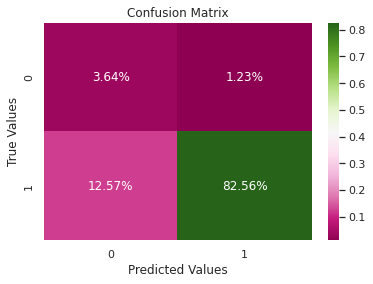

******************************




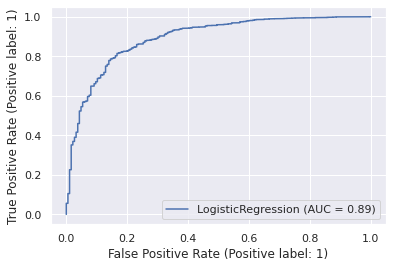

In [84]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

Even if the F1 score looks good lets explore the other algorithms

In [85]:
# Using the multinomial naive bayes character
from sklearn.naive_bayes import MultinomialNB

In [86]:
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 75.9%
Precision is : 98.9%
Recall is : 75.5%
F1 Score is : 85.6%
Roc-Auc Score is:87.5%
******************************


              precision    recall  f1-score   support

           0       0.15      0.84      0.25       186
           1       0.99      0.75      0.86      3632

    accuracy                           0.76      3818
   macro avg       0.57      0.80      0.55      3818
weighted avg       0.95      0.76      0.83      3818

******************************




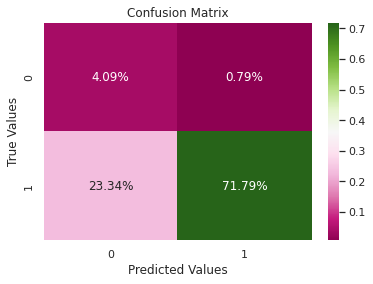

******************************




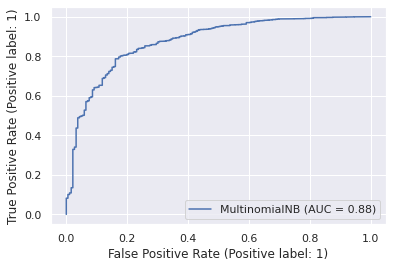

In [87]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

##### Decision Tree

In [88]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [89]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

In [90]:
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 82.5%
Precision is : 98.3%
Recall is : 83.0%
F1 Score is : 90.0%
Roc-Auc Score is:82.6%
******************************


              precision    recall  f1-score   support

           0       0.18      0.73      0.29       186
           1       0.98      0.83      0.90      3632

    accuracy                           0.83      3818
   macro avg       0.58      0.78      0.59      3818
weighted avg       0.94      0.83      0.87      3818

******************************




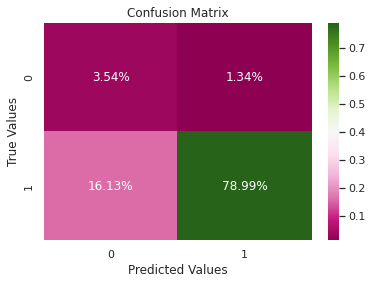

******************************




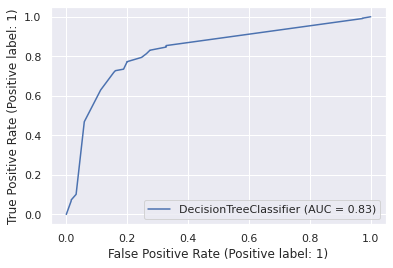

In [91]:
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

##### Random Forest

In [92]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

In [93]:
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

In [94]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

In [95]:
%time
grid_search.fit(X_train, y_train)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 20 µs
Fitting 4 folds for each of 64 candidates, totalling 256 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1', verbose=1)

In [96]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 79.0%
Precision is : 98.7%
Recall is : 79.0%
F1 Score is : 87.8%
Roc-Auc Score is:87.7%
******************************


              precision    recall  f1-score   support

           0       0.16      0.79      0.27       186
           1       0.99      0.79      0.88      3632

    accuracy                           0.79      3818
   macro avg       0.57      0.79      0.57      3818
weighted avg       0.95      0.79      0.85      3818

******************************




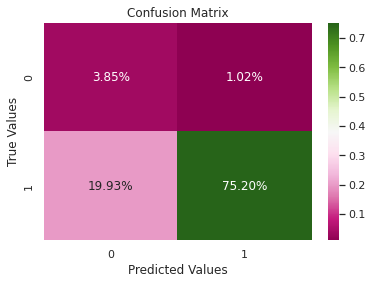

******************************




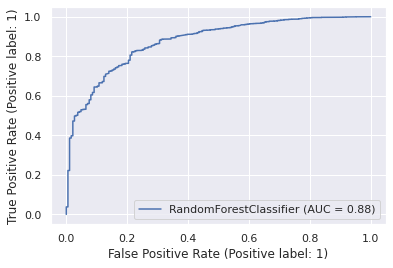

In [97]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

##### XG BOOST

In [98]:
import xgboost as xgb

In [99]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 92.8%
Precision is : 97.6%
Recall is : 94.8%
F1 Score is : 96.2%
Roc-Auc Score is:89.0%
******************************


              precision    recall  f1-score   support

           0       0.35      0.55      0.43       186
           1       0.98      0.95      0.96      3632

    accuracy                           0.93      3818
   macro avg       0.66      0.75      0.70      3818
weighted avg       0.95      0.93      0.94      3818

******************************




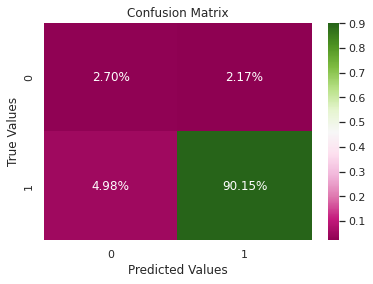

******************************




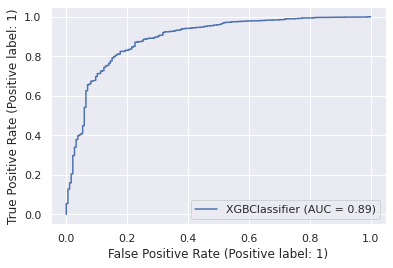

In [100]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

In [101]:
# Creating a dataframe which contains all the metrics from all models

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'], 
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics_cv,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest',
                                                    'XG Boost'] )

df_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,XG Boost
0,Accuracy,0.861970,0.758774,0.825301,0.790466,0.928497
1,Precision,0.985308,0.989174,0.983371,0.986598,0.976454
2,Recall,0.867841,0.754681,0.830396,0.790474,0.947687
3,F1Score,0.922852,0.856161,0.900433,0.877713,0.961856
4,Auc Score,0.892178,0.875383,0.826483,0.876533,0.890275


Comparing all the models we see that XG Boost is better than rest thus choosing the same

In [102]:
def save_object(obj, filename):
    filename = "pickle\\"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [103]:
save_object(xgclf, 'sentiment-classification-xg-boost-model')

In [104]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [105]:
save_object(df_correction, 'cleaned-data')

# ------------------------------END of Modelling-------------------------------------

# Recommendation System

### We are gonna try both the approaches of collaborative filtering techniques:

1. User-User based approach
2. Item-Item based approach

In [106]:
#using the orginal dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15271 entries, 0 to 15270
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    15271 non-null  object
 1   brand                 15271 non-null  object
 2   categories            15271 non-null  object
 3   manufacturer          15271 non-null  object
 4   name                  15271 non-null  object
 5   reviews_date          15257 non-null  object
 6   reviews_didPurchase   8928 non-null   object
 7   reviews_doRecommend   14702 non-null  object
 8   reviews_rating        15271 non-null  int64 
 9   reviews_text          15271 non-null  object
 10  reviews_title         15214 non-null  object
 11  reviews_userCity      1255 non-null   object
 12  reviews_userProvince  35 non-null     object
 13  reviews_username      15228 non-null  object
 14  user_sentiment        15271 non-null  int64 
dtypes: int64(2), object(13)
memory usage

In [107]:
df_recommendation = df[["id", "name", "reviews_rating", "reviews_username"]]

In [108]:
df_recommendation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15271 entries, 0 to 15270
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                15271 non-null  object
 1   name              15271 non-null  object
 2   reviews_rating    15271 non-null  int64 
 3   reviews_username  15228 non-null  object
dtypes: int64(1), object(3)
memory usage: 477.3+ KB


Since there are few null values in username column we will only use the records which have username present

In [109]:
df_recommendation = df_recommendation[~df_recommendation['reviews_username'].isna()]

In [110]:
df_recommendation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15228 entries, 0 to 15269
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                15228 non-null  object
 1   name              15228 non-null  object
 2   reviews_rating    15228 non-null  int64 
 3   reviews_username  15228 non-null  object
dtypes: int64(1), object(3)
memory usage: 594.8+ KB


In [111]:
#splitting the train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=92)

In [112]:
#checking the size of the splits
print(train.shape)
print(test.shape)

(11421, 4)
(3807, 4)


In [113]:
df_recommendation['id'].value_counts()

AVpf3VOfilAPnD_xjpun    8525
AVpf0eb2LJeJML43EVSt     845
AVpe41TqilAPnD_xQH3d     757
AVpf2tw1ilAPnD_xjflC     672
AVpe59io1cnluZ0-ZgDU     668
AV1l8zRZvKc47QAVhnAv     634
AVpe9W4D1cnluZ0-avf0     349
AV1YGDqsGV-KLJ3adc-O     348
AVpe8gsILJeJML43y6Ed     310
AVpe31o71cnluZ0-YrSD     247
AVpf4oLxLJeJML43FcxC     246
AVpf385g1cnluZ0-s0_t     196
AVpf0thK1cnluZ0-r8vR     139
AVpe5s3RLJeJML43x4eA     136
AV1YmDL9vKc47QAVgr7_      89
AV1YtGjdglJLPUi8IOfJ      72
AVpe6FpaLJeJML43yBuP      68
AVpe_y-I1cnluZ0-bmvh      63
AVpe6n2_LJeJML43yOgE      57
AV1ZT7GLglJLPUi8IQLI      50
AVpe7sl91cnluZ0-aI1Y      43
AVpe5JOgilAPnD_xQPfE      39
AV1YneDPglJLPUi8IJyQ      35
AV1Ymf_rglJLPUi8II2v      34
AVpf0YhQLJeJML43ETff      34
AVpe5c23LJeJML43xybi      32
AVpe6FfKilAPnD_xQmHi      29
AV16khLE-jtxr-f38VFn      27
AV1Yn94nvKc47QAVgtst      25
AVpf0O60ilAPnD_xizE6      24
AVpe4hlXLJeJML43xbrB      22
AVpe7zdzLJeJML43yp3d      22
AVpe8xjUilAPnD_xRkxC      20
AV1Ys0kTvKc47QAVgx1C      20
AVpf3okQLJeJML

#### Note: Here we see that values in id columns are repeated denoting that this are not review ids but rather are the product ids.

In [114]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index='reviews_username', columns = 'id', values = 'reviews_rating' ).fillna(0)
df_pivot.head(10)

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf_rYe1cnluZ0-ut8Y
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10ten,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [115]:
#Creating a dummy train and test
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [116]:
dummy_train.head()

,id,name,reviews_rating,reviews_username
2727,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),4,mdengineer
5829,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),5,xplnusa
3167,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),5,tp78
13077,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,nccouponmom
8493,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,smitty1636


In [117]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [118]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index='reviews_username', columns = 'id', values = 'reviews_rating').fillna(1)
dummy_train.head(10)

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf_rYe1cnluZ0-ut8Y
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1085,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10ten,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

In [119]:
df_pivot.index.nunique()

10539

In [120]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [121]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 1.]
 ...
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 1.]]
(10539, 10539)


Prediction for User-User

In [122]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       ...,
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 1.]])

In [123]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  0.        ,  2.23606798, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  4.10405591, 10.79252733, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 18.16667863, ...,  3.12347524,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , 18.16667863, ...,  3.12347524,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  6.34012389, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 18.16667863, ...,  3.12347524,
         0.        ,  0.        ]])

In [124]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf_rYe1cnluZ0-ut8Y
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,2.236068,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,7.071068,0.0,0.0,0.000000,0.000000,2.236068,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2.886751,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,4.896362,11.648364,0.000000,0.0,0.0
00sab00,0.0,4.104056,10.792527,0.0,0.0,0.000000,2.12132,0.000000,0.0,0.0,0.0,0.0,0.0,2.103419,2.103419,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.535534,0.0,0.000000,5.142160,0.0,0.0,0.0,0.000000,0.0,0.0,1.933473,1.282447,70.461921,0.0,...,0.0,0.0,0.000000,7.071068,0.0,0.0,0.0,2.500000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,10.772127,0.000000,0.0,2.208631,0.0,0.000000,3.123475,3.389573,2.886751,0.000000,0.0,0.000000,47.056585,0.0,0.0,5.632104,0.0,0.0,35.031139,9.000238,39.349200,0.000000,0.0,0.0
0325home,0.0,0.000000,18.166679,0.0,0.0,3.123475,7.00241,0.000000,0.0,0.0,0.0,0.0,0.0,2.474611,3.455191,0.0,0.693375,0.980581,0.0,0.0,0.0,7.071068,0.0,0.0,0.0,0.0,3.535534,0.0,3.535534,11.157077,0.0,0.0,0.0,39.349200,0.0,0.0,0.000000,0.000000,28.781430,0.0,...,0.0,0.0,3.535534,11.648364,0.0,0.0,0.0,12.045760,0.0,0.0,0.0,0.0,2.236068,0.0,0.0,1.856953,12.195788,2.236068,2.5,2.649065,0.0,2.236068,2.886751,1.436739,0.000000,3.535534,0.0,6.422285,41.768228,0.0,0.0,3.123475,0.0,0.0,15.110912,15.653472,0.000000,3.123475,0.0,0.0
06stidriver,0.0,0.000000,18.166679,0.0,0.0,3.123475,7.00241,0.000000,0.0,0.0,0.0,0.0,0.0,2.474611,3.455191,0.0,0.693375,0.980581,0.0,0.0,0.0,7.071068,0.0,0.0,0.0,0.0,3.535534,0.0,3.535534,11.157077,0.0,0.0,0.0,39.349200,0.0,0.0,0.000000,0.000000,28.781430,0.0,...,0.0,0.0,3.535534,11.648364,0.0,0.0,0.0,12.045760,0.0,0.0,0.0,0.0,2.236068,0.0,0.0,1.856953,12.195788,2.236068,2.5,2.649065,0.0,2.236068,2.886751,1.436739,0.000000,3.535534,0.0,6.422285,41.768228,0.0,0.0,3.123475,0.0,0.0,15.110912,15.653472,0.000000,3.123475,0.0,0.0
08dallas,0.0,0.000000,0.573539,0.0,0.0,0.000000,0.00000,2.649065,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00

Find top 20 recommendation for user

In [125]:
user_input = '00sab00' 
print(user_input)

00sab00


In [126]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

id
AVpe59io1cnluZ0-ZgDU    70.461921
AVpf0eb2LJeJML43EVSt    47.056585
AVpf3VOfilAPnD_xjpun    39.349200
AVpf2tw1ilAPnD_xjflC    35.031139
AV1YGDqsGV-KLJ3adc-O    10.792527
AVpe8gsILJeJML43y6Ed    10.772127
AVpf385g1cnluZ0-s0_t     9.000238
AVpe6FfKilAPnD_xQmHi     7.071068
AVpf0thK1cnluZ0-r8vR     5.632104
AVpe31o71cnluZ0-YrSD     5.142160
AV16khLE-jtxr-f38VFn     4.104056
AVpe-PJnLJeJML43ziaj     3.535534
AVpe_dxlilAPnD_xSiHI     3.389573
AVpe_N91LJeJML43z4jD     3.123475
AVpe_pDG1cnluZ0-bjSf     2.886751
AVpe6n2_LJeJML43yOgE     2.500000
AVpe5Mv4ilAPnD_xQQyy     2.461830
AVpe9W4D1cnluZ0-avf0     2.208631
AV1Ymf_rglJLPUi8II2v     2.121320
AV1YtGjdglJLPUi8IOfJ     2.103419
Name: 00sab00, dtype: float64

In [127]:
#display the top 20 product id, name and similarity_score 
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),70.461921
500,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),47.056585
1149,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,39.349200
7525,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),35.031139
8026,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),10.792527
8285,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",10.772127
8513,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",9.000238
8655,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,7.071068
8679,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),5.632104
8782,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),5.142160


Evaluation for User-User

In [128]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(513, 4)

In [129]:
common.head()

,id,name,reviews_rating,reviews_username
8185,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,ncdaddyof2
13556,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,mercury88
4118,AVpe8xjUilAPnD_xRkxC,The Honest Company Laundry Detergent,5,jessica
11036,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,couponingmo
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua


In [130]:
# convert into the user-item matrix.
common_user_based_matrix = pd.pivot_table(common,index='reviews_username', columns = 'id', values = 'reviews_rating')
common_user_based_matrix.head()

id,AV13O1A8GV-KLJ3akUyj,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6FpaLJeJML43yBuP,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf_rYe1cnluZ0-ut8Y
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
4djs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
7inthenest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
ac94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN


In [131]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10499,10500,10501,10502,10503,10504,10505,10506,10507,10508,10509,10510,10511,10512,10513,10514,10515,10516,10517,10518,10519,10520,10521,10522,10523,10524,10525,10526,10527,10528,10529,10530,10531,10532,10533,10534,10535,10536,10537,10538
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.780869,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780869,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.624695,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.624695,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
user_correlation_df['reviews_username'] = df_pivot.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10499,10500,10501,10502,10503,10504,10505,10506,10507,10508,10509,10510,10511,10512,10513,10514,10515,10516,10517,10518,10519,10520,10521,10522,10523,10524,10525,10526,10527,10528,10529,10530,10531,10532,10533,10534,10535,10536,10537,10538
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.780869,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.780869,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.624695,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
06stidriver,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.624695,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
08dallas,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [134]:
user_correlation_df_1.shape

(478, 10539)

In [135]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [136]:
user_correlation_df_3 = user_correlation_df_2.T

In [137]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 0.        ,  0.        ,  3.48330133, ...,  0.        ,
         3.53553391,  0.        ],
       [ 0.        ,  0.85749293,  0.5       , ...,  0.        ,
         5.        ,  0.        ],
       [ 0.        ,  0.85749293,  0.5       , ...,  0.        ,
         5.        ,  0.        ],
       ...,
       [ 0.        ,  0.85749293,  0.5       , ...,  0.        ,
         5.        ,  0.        ],
       [ 0.        ,  0.85749293,  0.5       , ...,  0.        ,
         5.        ,  0.        ],
       [ 0.        ,  0.        , 29.22941573, ...,  0.        ,
         0.        ,  0.        ]])

In [138]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index='reviews_username', columns = 'id', values = 'reviews_rating').fillna(0)

In [139]:
dummy_test.shape

(478, 36)

In [140]:
common_user_based_matrix.head()

id,AV13O1A8GV-KLJ3akUyj,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6FpaLJeJML43yBuP,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf_rYe1cnluZ0-ut8Y
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
4djs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
7inthenest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
ac94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN


In [141]:
dummy_test.head()

id,AV13O1A8GV-KLJ3akUyj,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6FpaLJeJML43yBuP,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf_rYe1cnluZ0-ut8Y
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7inthenest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ac94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [142]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [143]:
common_user_predicted_ratings.head()

id,AV13O1A8GV-KLJ3akUyj,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6FpaLJeJML43yBuP,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf_rYe1cnluZ0-ut8Y
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.697986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.545287,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.545287,0.0,0.0,0.0
7inthenest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.545287,0.0,0.0,0.0
ac94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.545287,0.0,0.0,0.0


In [144]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan  5. ... nan nan nan]]


In [145]:
common_ = pd.pivot_table(common,index='reviews_username', columns = 'id', values = 'reviews_rating')

In [146]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [147]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.6778250347706385


Item based recommendation system

In [148]:
df_pivot = pd.pivot_table(train,
    index='id',
    columns='reviews_username',
    values='reviews_rating'
)

df_pivot.head()

reviews_username,00dog3,00sab00,0325home,06stidriver,08dallas,1085,10ten,1234,1234561,1234567,123cat123,123charlie,123rs,123soccermom,127726,12cass12,1421nikki,1515,1943,19granny,1buzymom,1chynna,1cleaner,1gamer,1gussy,1hotmama,1izzy1,1jc1,1jodie,1kindword,1nikki31t,1officegal,1olaygal,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1witch,2014bestbuys,...,zakkwylde29,zanarkandruinsx2,zanzan73,zapman,zara0215,zarah,zaza,zchandyman,zebras,zeeleader,zegan,zenanuts,zenmon,zer0zer0agent,zhynellebb,zibber23,zibby4,zimmeyb,zippy,zitro,zmom,zoe1988,zombie,zombiedad80,zombiegirl22,zombiekiller,zone,zoney86,zooey_57,zotox,zout22389,zpalma,zsarah,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [150]:
df_subtracted.head()

reviews_username,00dog3,00sab00,0325home,06stidriver,08dallas,1085,10ten,1234,1234561,1234567,123cat123,123charlie,123rs,123soccermom,127726,12cass12,1421nikki,1515,1943,19granny,1buzymom,1chynna,1cleaner,1gamer,1gussy,1hotmama,1izzy1,1jc1,1jodie,1kindword,1nikki31t,1officegal,1olaygal,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1witch,2014bestbuys,...,zakkwylde29,zanarkandruinsx2,zanzan73,zapman,zara0215,zarah,zaza,zchandyman,zebras,zeeleader,zegan,zenanuts,zenmon,zer0zer0agent,zhynellebb,zibber23,zibby4,zimmeyb,zippy,zitro,zmom,zoe1988,zombie,zombiedad80,zombiegirl22,zombiekiller,zone,zoney86,zooey_57,zotox,zout22389,zpalma,zsarah,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.914634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ... -2.38244012e-02
   9.36824923e-04  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00 -2.38244012e-02 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.36824923e-04 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [152]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 9.36824923e-04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.36824923e-04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Prediction for Item-Item

In [153]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.0194539 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00289218, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00272079, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00108832, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00217664, ..., 0.        , 0.        ,
        0.        ]])

Filtering the rating only for the products not rated by the user for recommendation

In [154]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf_rYe1cnluZ0-ut8Y
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.019454,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.034925,0.0,0.0,0.0,0.0,0.014220,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.035301,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00607,0.0,0.0,0.0
00sab00,0.0,0.0,0.002892,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001483,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.027351,0.0,...,0.0,0.0,0.000000,0.008731,0.0,0.0,0.0,0.002333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000965,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.006662,0.000000,0.0,0.000000,0.003601,0.0,0.0,0.001117,0.0,0.0,0.001668,0.000876,0.00000,0.0,0.0,0.0
0325home,0.0,0.0,0.002721,0.0,0.0,0.0,0.003676,0.0,0.0,0.0,0.0,0.0,0.0,0.002973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.0,0.0,0.0,0.0,0.0,0.0,0.007676,0.010012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.004063,0.007587,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001747,0.0,0.0,0.0,0.007519,0.014505,0.004712,0.0,0.0,0.010855,0.006267,0.0,0.000000,0.001391,0.0,0.004505,0.000000,0.0,0.0,0.000000,0.0,0.0,0.003275,0.000000,0.00000,0.0,0.0,0.0
06stidriver,0.0,0.0,0.002721,0.0,0.0,0.0,0.003676,0.0,0.0,0.0,0.0,0.0,0.0,0.002973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001067,0.0,0.0,0.0,0.0,0.0,0.0,0.007676,0.010012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.004063,0.007587,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001747,0.0,0.0,0.0,0.007519,0.014505,0.004712,0.0,0.0,0.010855,0.006267,0.0,0.000000,0.001391,0.0,0.004505,0.000000,0.0,0.0,0.000000,0.0,0.0,0.003275,0.000000,0.00000,0.0,0.0,0.0
08dallas,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005410,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.016971,0.0,0.0,0.0,0.005585,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.017993,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.

Finding the top 20 recommendation for the user

In [155]:
# Take the user ID as input
user_input = '00sab00'
print(user_input)

00sab00


In [156]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

id
AVpe59io1cnluZ0-ZgDU    0.027351
AVpe6FfKilAPnD_xQmHi    0.008731
AVpe_pDG1cnluZ0-bjSf    0.006662
AVpf0eb2LJeJML43EVSt    0.003601
AV1YGDqsGV-KLJ3adc-O    0.002892
AVpe6n2_LJeJML43yOgE    0.002333
AVpf2tw1ilAPnD_xjflC    0.001668
AVpe31o71cnluZ0-YrSD    0.001483
AVpf0thK1cnluZ0-r8vR    0.001117
AVpe8gsILJeJML43y6Ed    0.000965
AVpf385g1cnluZ0-s0_t    0.000876
AVpe7jB8LJeJML43yj91    0.000000
AV14LG0R-jtxr-f38QfS    0.000000
AVpe7sl91cnluZ0-aI1Y    0.000000
AVpe7tA31cnluZ0-aI-r    0.000000
AVpe7zdzLJeJML43yp3d    0.000000
AVpe7GIELJeJML43yZfu    0.000000
AVpe6_VI1cnluZ0-Z4do    0.000000
AVpe78stLJeJML43ytOY    0.000000
AVpe71Vk1cnluZ0-aL_Z    0.000000
Name: 00sab00, dtype: float64

In [157]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),0.027351
500,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,0.008731
524,AVpe_pDG1cnluZ0-bjSf,Bi-O-kleen Spray & Wipe All Purpose Cleaner,0.006662
532,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),0.003601
1181,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.002892
1440,AVpe6n2_LJeJML43yOgE,Tresemme Kertatin Smooth Infusing Conditioning,0.002333
1488,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),0.001668
1989,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),0.001483
2167,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),0.001117
2270,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",0.000965


In [158]:
common =  test[test.id.isin(train.id)]
common.shape

(3801, 4)

In [159]:
common.head(4)

,id,name,reviews_rating,reviews_username
3054,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),5,nessarei
6901,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,4,yari1
4064,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",5,sparkle
7441,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,4,reviewer1236


In [160]:
common_item_based_matrix = common.pivot_table(index='id', columns='reviews_username', values='reviews_rating')

In [161]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002398,0.0,0.0,0.0,0.0,0.0,0.0,0.0386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011246,0.000912,0.0,0.0,0.0,0.002892,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.004863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002559,0.0,0.0,0.0,0.0,0.004251,0.0,0.0,0.0,0.015904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004064,0.000544,0.0,0.000937,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.021089,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [163]:
list_name = common.id.tolist()

In [164]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [165]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [166]:
df_subtracted

reviews_username,00dog3,00sab00,0325home,06stidriver,08dallas,1085,10ten,1234,1234561,1234567,123cat123,123charlie,123rs,123soccermom,127726,12cass12,1421nikki,1515,1943,19granny,1buzymom,1chynna,1cleaner,1gamer,1gussy,1hotmama,1izzy1,1jc1,1jodie,1kindword,1nikki31t,1officegal,1olaygal,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1witch,2014bestbuys,...,zakkwylde29,zanarkandruinsx2,zanzan73,zapman,zara0215,zarah,zaza,zchandyman,zebras,zeeleader,zegan,zenanuts,zenmon,zer0zer0agent,zhynellebb,zibber23,zibby4,zimmeyb,zippy,zitro,zmom,zoe1988,zombie,zombiedad80,zombiegirl22,zombiekiller,zone,zoney86,zooey_57,zotox,zout22389,zpalma,zsarah,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.914634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,NaN,NaN,NaN,NaN,-3.180556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1Ymf_rglJLPUi8II2v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1Yn94nvKc47QAVgtst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1Ynb3bglJLPUi8IJxJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.72079388e-03, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.72079388e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.81047477e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [168]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index='id', columns='reviews_username', values='reviews_rating').fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [169]:
common_ = pd.pivot_table(common,index='id', columns='reviews_username', values='reviews_rating')

In [170]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [171]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [172]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.723307439925898


Comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2)

In [173]:
# saving the correlation matrix of user based recommender 
save_object(user_final_rating, "user_final_rating")

#### Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model
Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.. the similar method would be used in model.py

In [174]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_correction[df_correction.id.isin(recommendations)]
        X =  tfidf_vectorizer.transform(temp["reviews_combine"].values.astype(str))
        temp["predicted_sentiment"]= xgclf.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [175]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("00sab00")

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
3,Bi-O-kleen Spray & Wipe All Purpose Cleaner,8,8,8,100.00
8,Happy Tot Apple and Butternut Squash,9,9,9,100.00
6,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8486,8545,99.31
4,Cars Toon: Mater's Tall Tales,34,33,34,97.06
15,The Resident Evil Collection 5 Discs (blu-Ray),845,795,845,94.08
14,Red (special Edition) (dvdvideo),672,612,672,91.07
0,100:Complete First Season (blu-Ray),139,125,139,89.93
13,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",310,264,310,85.16
9,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,362,307,362,84.81
17,Tresemme Kertatin Smooth Infusing Conditioning,57,47,57,82.46


In [176]:
#get the top 5
get_sentiment_recommendations("00sab00")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
3,Bi-O-kleen Spray & Wipe All Purpose Cleaner,8,8,8,100.00
8,Happy Tot Apple and Butternut Squash,9,9,9,100.00
6,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8486,8545,99.31
4,Cars Toon: Mater's Tall Tales,34,33,34,97.06
15,The Resident Evil Collection 5 Discs (blu-Ray),845,795,845,94.08


In [177]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("new_user123")

User name new_user123 doesn't exist


In [178]:
X_sample = tfidf_vectorizer.transform(["Awesome product, will surely recommend"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

array([1])

In [179]:
X_sample = tfidf_vectorizer.transform(["Worst product, poor quality"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

array([0])

In [181]:
#Code to get the version for read me file
import sklearn
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

1.0.2
1.19.5
1.3.5
3.2.5


In [182]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
